In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import time
import numpy as np
!pip3 install dtreeviz
from dtreeviz.trees import dtreeviz

     |████████████████████████████████| 72 kB 1.8 MB/s eta 0:00:011
     |████████████████████████████████| 316 kB 8.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


### Dataset D

In assignment, label "Caff" has the highest overall accuracy among the 4 models (0.9743). I will use this label to construct dataset D.

In [2]:
columns = [
           "ID", "Age", "Gender", "Education", "Country", 
           "Ethnicity", "Nscore", "Escore", "Oscore", 
           "Ascore", "Cscore", "Impulsive", "SS", 
           "Alcohol", "Amphet", "Amyl", "Benzos", 
           "Caff", "Cannabis", "Choc", "Coke", 
           "Crack", "Ecstasy", "Heroin", "Ketamine", 
           "Legalh", "LSD", "Meth", "Mushrooms", 
           "Nicotine", "Semer", "VSA"
           ]

dataset = pd.read_csv("./drug_data/drug_consumption.data", header = None, names=columns)

In [3]:
dataset_d = dataset[["Age", "Gender", "Education", "Country", 
           "Ethnicity", "Nscore", "Escore", "Oscore", 
           "Ascore", "Cscore", "Impulsive", "SS", "Cannabis"]]

dataset_d.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Cannabis
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL4
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL3
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL2
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL3


In [4]:
features = dataset_d.iloc[:,:12]

In [5]:
# Ordinal feature: Age, Education, Nscore, Escore, Oscore, Ascore, Cscore, Impulsive, SS
# Nominal feature: Gender, Country, Ethnicity

# gender is binary so we don't need to encode it here
nominal_f = ['Country', 'Ethnicity']
new_columns = ['USA', 'New Zealand', 'Country_Other', 
               'Australia', 'Ireland', 'Canada', 'UK',
               'Black', 'Asian', 'White', 'Mixed-White/Black',
               'Ethnicity_Other', 'Mixed-White/Asian', 'Mixed-Black/Asian'
              ]

# one hot encode the nominal features
one_hot_features = pd.concat([pd.get_dummies(features[col], prefix=col) for col in nominal_f], axis=1)
# rename the columns after one-hot
one_hot_features = one_hot_features.rename(dict(zip(one_hot_features.columns, new_columns)), axis="columns")
one_hot_features.head()

,USA,New Zealand,Country_Other,Australia,Ireland,Canada,UK,Black,Asian,White,Mixed-White/Black,Ethnicity_Other,Mixed-White/Asian,Mixed-Black/Asian
0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [6]:
scaler = MinMaxScaler()
ordinal_f = features.drop(nominal_f, axis=1)
norm_ordinal_f = scaler.fit(ordinal_f).transform(ordinal_f)
norm_ordinal_f = pd.DataFrame(norm_ordinal_f, columns=ordinal_f.columns)
norm_ordinal_f.head()

,Age,Gender,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
0,0.409137,1.0,0.537681,0.560562,0.412116,0.435690,0.367654,0.499040,0.428474,0.224398
1,0.246475,0.0,1.000000,0.413474,0.796106,0.762567,0.609827,0.479394,0.337920,0.465658
2,0.409137,0.0,0.537681,0.444788,0.622976,0.392939,0.266061,0.353580,0.215401,0.619957
3,0.000000,1.0,0.814329,0.492045,0.376883,0.527023,0.585213,0.584415,0.215401,0.224398
4,0.409137,1.0,1.000000,0.623275,0.250544,0.456995,0.456454,0.688508,0.428474,0.465658


In [7]:
# concat norminal and ordinal features together
processed_features = pd.concat([norm_ordinal_f, one_hot_features], axis=1)
processed_features.head()

,Age,Gender,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,...,Ireland,Canada,UK,Black,Asian,White,Mixed-White/Black,Ethnicity_Other,Mixed-White/Asian,Mixed-Black/Asian
0,0.409137,1.0,0.537681,0.560562,0.412116,0.435690,0.367654,0.499040,0.428474,0.224398,...,0,0,1,0,0,0,0,0,1,0
1,0.246475,0.0,1.000000,0.413474,0.796106,0.762567,0.609827,0.479394,0.337920,0.465658,...,0,0,1,0,0,1,0,0,0,0
2,0.409137,0.0,0.537681,0.444788,0.622976,0.392939,0.266061,0.353580,0.215401,0.619957,...,0,0,1,0,0,1,0,0,0,0
3,0.000000,1.0,0.814329,0.492045,0.376883,0.527023,0.585213,0.584415,0.215401,0.224398,...,0,0,1,0,0,1,0,0,0,0
4,0.409137,1.0,1.000000,0.623275,0.250544,0.456995,0.456454,0.688508,0.428474,0.465658,...,0,0,1,0,0,1,0,0,0,0


In [8]:
dataset_d.iloc[:,12:]

,Cannabis
0,CL0
1,CL4
2,CL3
3,CL2
4,CL3
...,...
1880,CL5
1881,CL3
1882,CL6
1883,CL6


In [10]:
# encode the labels
# 0: CL0 and CL1 (Non user)
# 1: other classes (User)

labels = dataset_d.iloc[:,12:]
labels.loc[(labels.Cannabis == 'CL0') | (labels.Cannabis == 'CL1'), "Cannabis"] = 0
labels.loc[labels.Cannabis != 0, "Cannabis"] = 1
labels = labels.astype('int')
labels.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,Cannabis
0,0
1,1
2,1
3,1
4,1


In [11]:
dataset_d = pd.concat([processed_features, labels], axis=1)
dataset_d.head()

,Age,Gender,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,...,Canada,UK,Black,Asian,White,Mixed-White/Black,Ethnicity_Other,Mixed-White/Asian,Mixed-Black/Asian,Cannabis
0,0.409137,1.0,0.537681,0.560562,0.412116,0.435690,0.367654,0.499040,0.428474,0.224398,...,0,1,0,0,0,0,0,1,0,0
1,0.246475,0.0,1.000000,0.413474,0.796106,0.762567,0.609827,0.479394,0.337920,0.465658,...,0,1,0,0,1,0,0,0,0,1
2,0.409137,0.0,0.537681,0.444788,0.622976,0.392939,0.266061,0.353580,0.215401,0.619957,...,0,1,0,0,1,0,0,0,0,1
3,0.000000,1.0,0.814329,0.492045,0.376883,0.527023,0.585213,0.584415,0.215401,0.224398,...,0,1,0,0,1,0,0,0,0,1
4,0.409137,1.0,1.000000,0.623275,0.250544,0.456995,0.456454,0.688508,0.428474,0.465658,...,0,1,0,0,1,0,0,0,0,1


In [12]:
print("Number of class 0 in train:", len(dataset_d[dataset_d['Cannabis']==0]))
print("Number of class 1 in train:", len(dataset_d[dataset_d['Cannabis']==1]))

Number of class 0 in train: 620
Number of class 1 in train: 1265


### Retraining the dataset D with 10-fold CV for the 4 models

In [84]:
# a pipeline and parameters for decision tree
pipe_dt = Pipeline([
    ("feature_selection", SelectKBest(chi2)),
    ("Decision_tree", DecisionTreeClassifier(random_state=42))])


param_distributions_dt = {
    "feature_selection__k": range(10, 24), # best-k features to select
    "Decision_tree__max_depth": range(1, 4),
    "Decision_tree__min_samples_split": range(2, 10),
}


model_names = ["Decision_tree"]
model_pipes = [pipe_dt]
model_params = [param_distributions_dt]

In [85]:
def train(X, y, model_names, model_pipes, model_params, cv=10):
    best_models = []
    for i, name in enumerate(model_names):
        start = time.time()
        print(name + ":")
        
        # random search to find the best hyper-parameters
        clf = GridSearchCV(model_pipes[i], model_params[i], cv=cv, scoring="accuracy")
        search = clf.fit(X, y)
        print('Best parameters found:\n', search.best_params_)
        print("Best accuracy Score for 10-fold:", search.best_score_)
        best_models.append(search.best_estimator_)
        
        print("Time:", time.time()-start)
    return best_models

In [86]:
# train four models on dataset D with 10-fold CV
best_models= train(processed_features, labels.to_numpy().reshape(-1), 
      model_names, model_pipes, model_params, cv=10)

Decision_tree:
Best parameters found:
 {'Decision_tree__max_depth': 3, 'Decision_tree__min_samples_split': 2, 'feature_selection__k': 11}
Best accuracy Score for 10-fold: 0.7815349544072949
Time: 24.755724906921387


### Display/visualized the resultant model created by the decision tree

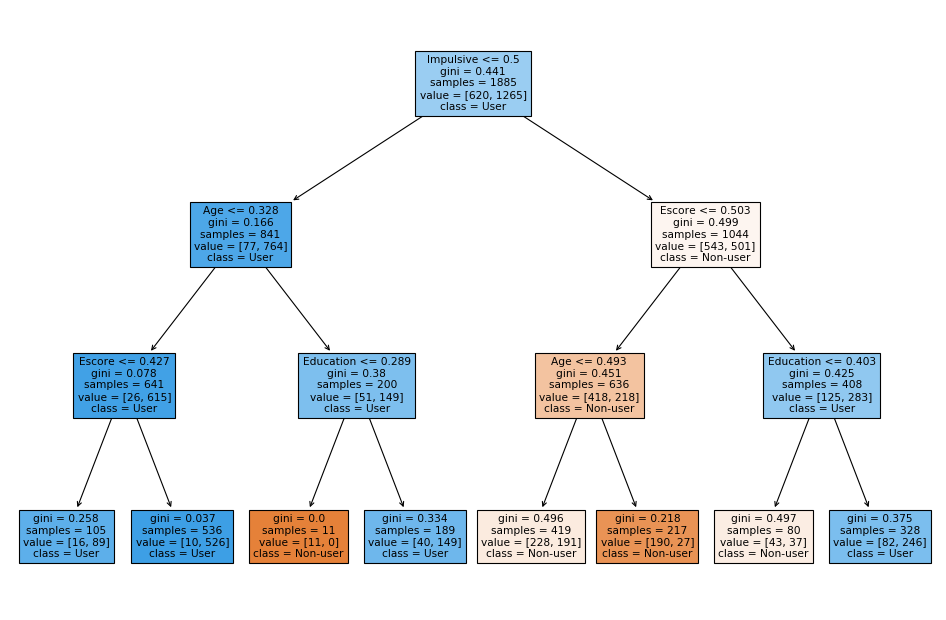

In [103]:
fig = plt.figure(figsize=(15,10), dpi=80)
tree.plot_tree(best_models[0]['Decision_tree'], 
               feature_names = processed_features.columns,
               class_names = ['Non-user' , 'User'],
               filled=True)
plt.savefig("sktree.png")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


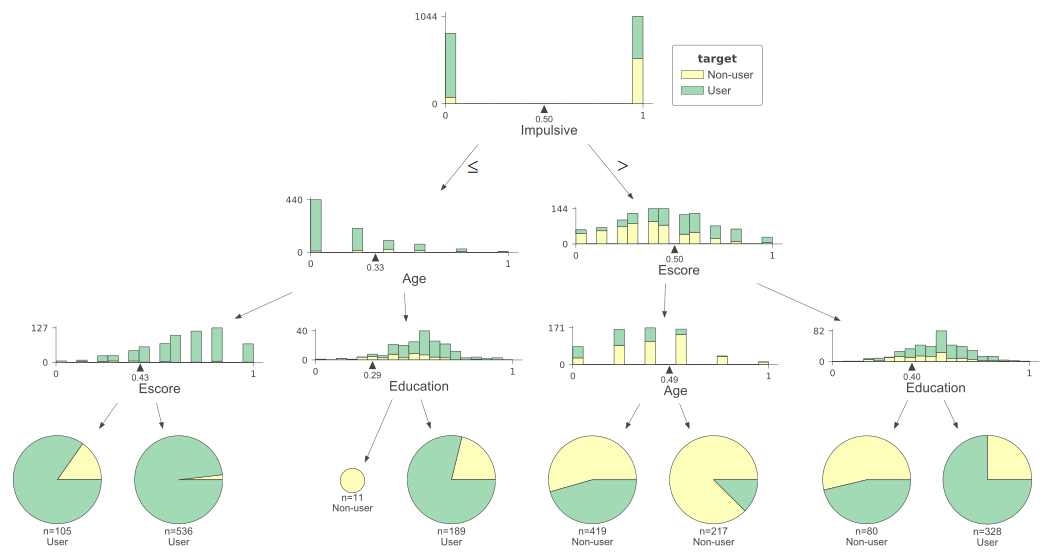

In [105]:
from dtreeviz.trees import dtreeviz # remember to load the package
viz = dtreeviz(best_models[0]['Decision_tree'], 
               processed_features[processed_features.columns[best_models[0]['feature_selection'].get_support()]], 
               labels.to_numpy().reshape(-1),
               target_name="target",
               feature_names=processed_features.columns,
               class_names=['Non-user' , 'User'])

viz.scale = 1.5
viz.save("dtreeviz_tree.svg")
viz